Check also https://www.authorea.com/users/173169/articles/208172-october-25-2017-summary-of-individual-fish-stochastic-swimming-model-and-fitting-results

Check coordinate system.

In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.optimize import curve_fit
from numba import jit

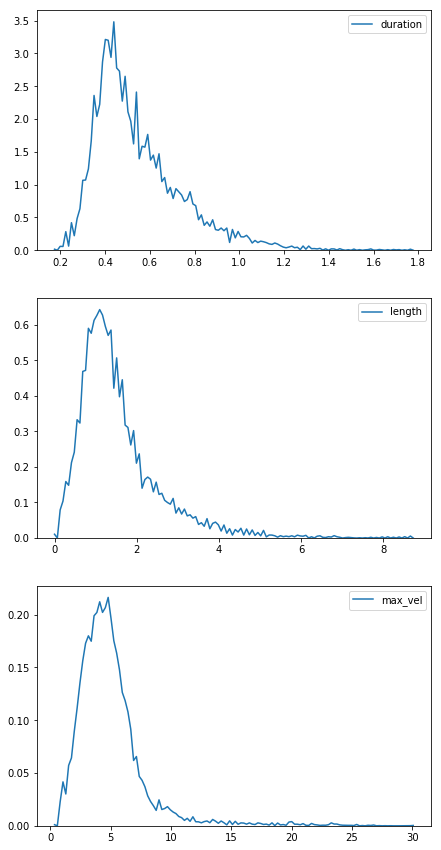

In [2]:
df = pd.read_csv("../../data/processed/kicks_guy.csv")
# TODO: Move to other notebook
fig, ax = plt.subplots(3, figsize=(5*2**(0.5), 3*5))
sns.kdeplot(df['duration'], bw=.002, ax=ax[0])
sns.kdeplot(df['length'],bw=.002, ax=ax[1])
sns.kdeplot(df['max_vel'], bw=.002, ax=ax[2])

In [3]:
#df = df.drop(df[df['neighbor_distance'] < 10].index) # No kicks where fish are close
#df = df.drop(df[df['geometric_leader'] != 'f0'].index) 
df = df.drop(df[df['fish_id'] != 'f0'].index)

df.index = np.arange(0, len(df))
#df.index = np.arange(0, len(df))
df.describe()

,heading_change,duration,length,max_vel,neighbor_distance,neighbor_angle,viewing_angle_ltf,viewing_angle_ftl,rel_orientation,wall_distance0_f0,...,wall_angle2_f0,wall_angle3_f0,wall_distance0_f1,wall_distance1_f1,wall_distance2_f1,wall_distance3_f1,wall_angle0_f1,wall_angle1_f1,wall_angle2_f1,wall_angle3_f1
count,6784.000000,6784.000000,6784.000000,6784.000000,6784.000000,6784.000000,6784.000000,6784.000000,6784.000000,6784.000000,...,6784.000000,6784.000000,6784.000000,6784.000000,6784.000000,6784.000000,6784.000000,6784.000000,6784.000000,6784.000000
mean,0.008552,0.538863,1.522946,5.440241,2.479233,-0.059855,-0.265604,0.047351,-0.000803,14.612968,...,-1.454347,0.109040,14.715829,15.833431,15.284171,14.166569,1.611196,0.079299,-1.461860,0.083930
std,1.095759,0.187333,0.905214,3.186719,1.878920,1.801038,2.090338,1.392602,1.097144,9.917437,...,0.964178,2.415824,9.522997,9.447914,9.522997,9.447914,0.967373,0.907518,0.947914,2.418611
min,-3.131853,0.180106,0.000953,0.414433,0.398733,-3.140936,-3.141578,-3.113466,-3.135455,0.453870,...,-3.139016,-3.140573,0.458591,0.126454,0.474596,0.617473,-3.136529,-2.262596,-3.140601,-3.141572
25%,-0.352397,0.410242,0.926039,3.650613,1.773567,-1.584253,-2.217863,-1.036241,-0.384209,4.379720,...,-2.159067,-2.183619,4.952835,6.703899,5.878567,4.690485,0.941217,-0.613175,-2.166704,-2.198063
50%,0.037572,0.480283,1.339702,4.908141,2.233612,-0.178482,-0.923639,0.141045,0.004214,14.413633,...,-1.567789,1.479474,14.885703,16.436688,15.114297,13.563312,1.556526,-0.002077,-1.562976,1.162665
75%,0.408813,0.640378,1.873063,6.272998,2.782209,1.568082,1.844861,1.061631,0.382453,24.441556,...,-0.609767,2.549674,24.121433,25.309515,25.047165,23.296101,2.492570,0.940566,-0.613804,2.530731
max,3.138190,1.711010,7.713041,30.056470,30.505288,3.141502,3.140943,3.135925,3.131667,29.555242,...,3.141418,3.141189,29.525404,29.382527,29.541409,29.873546,3.139827,2.049724,3.140249,3.141498


In [4]:
# Select only entries where the kicking fish is the focal one
heading_change = df['heading_change'].values
wall_distance0 = df['wall_distance0_f0'].values
wall_angle0 = -df['wall_angle0_f0'].values
wall_distance1 = df['wall_distance0_f1'].values
wall_angle1 = -df['wall_angle0_f1'].values
leader = df['geometric_leader'].values
fish_id = df['fish_id'].values

# Discretize into I x J boxes
I = 40 # 40
J = 30 # 30
WALL_RADIUS = 14
boxlim_f = np.linspace(0, WALL_RADIUS, I + 1)
boxlim_O = np.linspace(-np.pi, np.pi, J + 1)

f = np.zeros(I )# 0... radius=14
O = np.zeros(J) # -pi ... pi

In [5]:
boxcount = np.zeros((I,J)) + 1 # dirty hack
boxheading = np.zeros((I,J))
for i in range(0, len(wall_distance0)):
    wall_distance = None
    wall_angle = None
    #if leader[i] != fish_id[i]:
    #    continue
    if fish_id[i] == 'f0':
        wall_distance = wall_distance0[i]
        wall_angle = wall_angle0[i]
    else:
        wall_distance = wall_distance1[i]
        wall_angle = wall_angle1[i]
        
    box_f = np.digitize(wall_distance, boxlim_f, right=False) - 1
    box_O = np.digitize(wall_angle, boxlim_O, right=False) - 1
    boxcount[box_f, box_O] += 1
    boxheading[box_f, box_O] += heading_change[i]
    
    # Add inverse angle as well
    box_f = np.digitize(wall_distance, boxlim_f, right=False) - 1
    box_O = np.digitize(-wall_angle, boxlim_O, right=False) - 1
    boxcount[box_f, box_O] += 1
    boxheading[box_f, box_O] += -heading_change[i]
    
# No entry in box -> average heading is zero!
with np.errstate(divide='ignore'):
    boxheading = np.divide(boxheading, boxcount)
boxheading[np.isnan(boxheading)] = 0

IndexError: index 40 is out of bounds for axis 0 with size 40

In [ ]:
# Fitting
def step(f, O):

    oldF = np.copy(f)
    damping = 0.25
    for i in range(0, I):
        newF = np.sum(boxcount[i] * boxheading[i] * O) / np.sum(boxcount[i] * O**2)
        #if np.isnan(newF):
        #    newF = f[i]
        #print(newF)
        f[i] = (1 - damping) * f[i] + damping * newF
    
    for j in range(0, J):
        newO = np.sum(boxcount[:,j] * boxheading[:,j] * f) / np.sum(boxcount[:,j] * f**2)
        #if np.isnan(newO):
        #    newO = O[j]
        O[j] = (1 - damping) * O[j] + damping * newO
    
    # Normalize J s.t. its average square is one
    norm = (np.sum(O**2)/J)**0.5 #np.linalg.norm(O*2)
    if norm >= 10e-2:
        O = (O / norm)
        f = (f * norm)

    return f, O

In [ ]:
j = 8
np.sum(boxcount[:,j] * boxheading[:,j] * f) / np.sum(boxcount[:,j] * f**2), O[j]

In [ ]:
convergence = 10e-10

# Init f and O with 'reasonable' values
f = np.exp(-(boxlim_f[:I]/4)**2)
#f = np.zeros(boxlim_f[:I].shape) + 10

O = np.sin(boxlim_O[:J])# odd function + 1

# Optimize
for i in range(0, 1000):
    oldF = np.copy(f)
    oldO = np.copy(O)
    f, O = step(f, O)
    if (np.linalg.norm(oldO - O) <= convergence and np.linalg.norm(oldF - f) <= convergence):
        print(f"Converged after {i} iterations!")
        break
print(i)

In [ ]:
# Estimate similar functional forms to paper
def wall_distance(x, l_d, s_d):
    return s_d * np.exp(-(x/l_d)**2 )

#https://stackoverflow.com/questions/32590720/create-scipy-curve-fitting-definitions-for-fourier-series-dynamically
def angle_fun(x, *a):
    ret = 1
    for deg in range(1, len(a)):
        ret += a[deg] * np.cos(deg * x)
    return a[0] * np.sin(x) * ret

a, _ = curve_fit(angle_fun, boxlim_O[1:], O[:], [1.0] * 5)
print(a[0])
O /= a[0]
f *= a[0]
a, _ = curve_fit(angle_fun, boxlim_O[1:], O[:], [1.0] * 3)

l_d, s_d = curve_fit(wall_distance, boxlim_f[1:], f[0:])[0]

print(f"Fallof {l_d}, in BL {l_d/0.6}")
print(a)

plt.scatter(boxlim_f[1:], f[:])
plt.axhline(0, linestyle='dotted')
plt.plot(boxlim_f[1:], wall_distance(boxlim_f[1:], l_d, s_d), c='orange')
plt.title("Strength vs distance")

plt.figure()
plt.scatter(np.rad2deg(boxlim_O[1:]), O[0:])
plt.plot(np.rad2deg(boxlim_O[1:]), angle_fun(boxlim_O[1:], *a), c='orange')

plt.axhline(0, linestyle='dotted')
plt.axvline(90, linestyle='dotted', c='g')
plt.axvline(-90, linestyle='dotted', c='g')
plt.title("Heading vs angle to wall")

In [32]:
spearmanr(ydata, -fitted_model(xdata_wall))

SpearmanrResult(correlation=-0.20029441857555377, pvalue=2.4210476695383782e-62)

In [7]:
# Try grad.desc as a sanity check
def calc_wall_error(model, xdata, ydata, params=None):
    lambda_reg = 0.0
    return np.linalg.norm (model(xdata) - ydata)

#fCur = lambda dist: f(dist, 1.9)
#OCur = lambda angle: O(angle, 0.8, 0.0)
#calc_wall_error(heading_change, wall_distance0, wall_angle0, fCur, OCur)

def compute_r2(model, x, y):
    residuals = y - model(x)
    ss_res = np.sum(residuals**2)
    ss_tot = np.sum((y - np.mean(y))**2)
    return 1 - (ss_res/ss_tot)

In [33]:
from scipy.optimize import minimize, least_squares, curve_fit
from scipy.integrate import quad
from scipy.stats import spearmanr
np.set_printoptions(suppress=True)

heading_change = df['heading_change'].values
wall_distance0 = np.vstack([df[f'wall_distance{i}_f0'].values for i in range(4)])
wall_angle0 = np.vstack([-df[f'wall_angle{i}_f0'].values for i in range(4)])


# TODO: using closest_wall_idx is very buggy currently!
num_walls = 4 # only consider the num_walls closest walls
closest_wall_idx = np.unravel_index(np.argpartition(wall_distance0, num_walls)[:num_walls], wall_distance0.shape)
#xdata_wall = np.vstack((wall_distance0[closest_wall_idx], wall_angle0[closest_wall_idx]))
xdata_wall = np.vstack((wall_distance0, wall_angle0))

# Double data by magic
reflect = False
if reflect:  
    pass
#    xdata_wall_reflected = np.vstack(( wall_distance0, -wall_angle0))
 #   heading_change_reflected = -heading_change
#    xdata_wall = np.hstack((xdata_wall, xdata_wall_reflected))
#    ydata = np.hstack((heading_change, heading_change_reflected))
else:
    ydata = heading_change

# Model
angular_model = 'shifted-sin-cos'

angular = {'calovi': lambda angle, p1, p2: np.sin(angle) * (1 + p1 * np.cos(2*angle) + p2*np.cos(4*angle) ),
         'sin': lambda angle, p1, p2, p3: p1 * np.sin(angle) + p2 * np.sin( 2 * angle ) + p3 * np.sin( 3* angle),
         'sin-cos': lambda angle, a1, a2, b1, b2 : (a1 * np.sin(angle) + a2 * np.sin(2*angle)) * \
            (b1 * np.cos(angle) + b2 * np.cos(2*angle) + 1),
         'shifted-sin-cos': lambda angle, a1, a2, b1, b2:
                (a1 * np.cos(angle) + a2 * np.sin(2 * (angle + np.pi/2))) *
                (-b1 * np.sin(angle) + b2 * np.cos(2 * (angle + np.pi/2))+ 1)}
init_x = {'calovi': np.array([6, 1.0, 0.7, 0.0]),
          'sin':  np.array([6, 1.0, 0.7, 0.0, 0.0]),
          'sin-cos': np.array([6, 1.0, 1.0, 1.0, 1.0, 1.0]),
          'shifted-sin-cos': np.array([6, 1.0, 1.0, 1.0, 1.0, 1.0])}

f = lambda dist, *params: params[1] * np.exp(-(dist/params[0])**2 )
O = angular[angular_model]

def model_wall(xdata, *params):
    fCur = lambda dist: f(dist, *params[0:2])
    OCur = lambda angle: O(angle, *params[2:])  
    return 0.5 * np.sum( [fCur(xdata[i]) * OCur(xdata[i + num_walls]) for i in range(num_walls)], axis=0 )

x0 = init_x[angular_model]

l_bounds = np.array([-np.inf] * len(x0))
u_bounds = np.array([ np.inf] * len(x0))
l_bounds[0] = 0.0 # no negative decay
bounds = (l_bounds, u_bounds)

res = curve_fit(model_wall, xdata=xdata_wall, ydata=ydata, p0=x0, bounds=bounds,max_nfev=1000000)
x_opt_wall = res[0]

fitted_model = lambda xdata: model_wall(xdata, *x_opt_wall)
random_model = lambda xdata: model_wall(xdata, *x0)
mean_model = lambda xdata: np.ones_like(xdata) * np.mean(ydata)

print(f"Curve fit reached error of {calc_wall_error(fitted_model, xdata_wall, ydata, x_opt_wall)} with params={str(x_opt_wall)}")
print(f"1-Std-error of params is {np.sqrt(np.diag(res[1]))}")
print(f"Random params reached error of {calc_wall_error(random_model, xdata_wall, ydata, x0)} with params={x0}")

# Calculate error for mean heading change as model
mean_heading_error = calc_wall_error(mean_model, xdata_wall, ydata, np.array([0.0]))
print(f"Predicting the average heading {np.mean(ydata)} for each heading leads to an error of {mean_heading_error}")

print(f"Model has r^2 of {compute_r2(fitted_model, xdata_wall, ydata)}")
yHat = fitted_model(xdata_wall)
print(f"Correlation={np.corrcoef(ydata, yHat)[0][1]}")

Curve fit reached error of 87.1019611885712 with params=[ 14.08271817   0.09959818   0.09158035   1.51636642  -0.35623836
   6.15803168]
1-Std-error of params is [       2.00725001   228246.15508056   209871.9383402   3475011.21561282
        0.59240331        9.65201815]
Random params reached error of 96.28955613113813 with params=[ 6.  1.  1.  1.  1.  1.]
Predicting the average heading 0.008551857728386725 for each heading leads to an error of 255.2529956365961
Model has r^2 of 0.06845431370992772
Correlation=0.26583855767223247


In [28]:
#def loss_wall(params):
#    lambda_reg = 10e-6
#    yHat = model_wall(xdata_wall, *params)
#    return np.mean(np.square(ydata - yHat)) + lambda_reg * np.linalg.norm(params)

#res = minimize(loss_wall, x0)
#fitted_model = lambda xdata: model_wall(xdata, *res.x)
#print(f"Model has r^2 of {compute_r2(fitted_model, xdata_wall, ydata)}")
#yHat = fitted_model(xdata_wall)
#print(f"Correlation={np.corrcoef(ydata, yHat)[0][1]}")
#print(res.x)

0.0995981837466 12.130567294777366
Multiplier is 1.2081824703761148


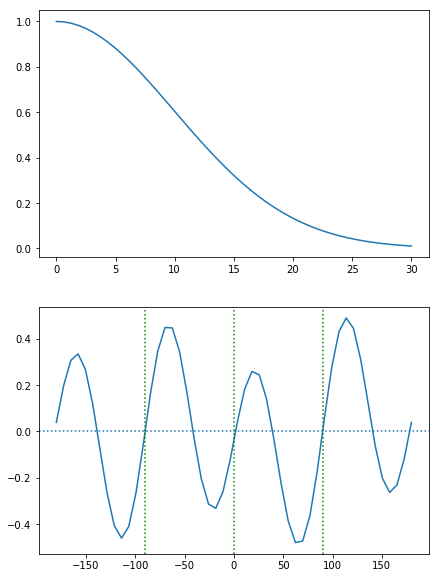

In [34]:
def get_norm_const(OCur, angles):
    return 1/(2*np.pi) * quad(lambda a: OCur(a)**2, -np.pi, np.pi)[0]

def plotFit(params, angles):
    fCur = lambda dist: f(dist, params[0],1.0) # no scaling here
    OCur = lambda angle: O(angle, *params[2:]) 
    norm_const = get_norm_const(OCur, angles)
    print(params[1], norm_const)
    print(f"Multiplier is {norm_const * params[1]}")
    
    fig, ax = plt.subplots(2, 1, figsize=(7,10) )
    
    ax[0].plot(np.linspace(0, 30), fCur(np.linspace(0,30)))
    ax[1].plot(np.rad2deg(np.linspace(-np.pi, np.pi)), OCur(np.linspace(-np.pi, np.pi))/norm_const)
    plt.axhline(0, linestyle='dotted')
    ax[1].axvline(90, linestyle='dotted', c='g')
    ax[1].axvline(0.0, linestyle='dotted', c='g')
    ax[1].axvline(-90, linestyle='dotted', c='g')
plotFit(x_opt_wall, ydata)

In [ ]:
from itertools import product
[ f"wall_{type}{wall}_{id}" for id, type, wall in product( ['f0', 'f1'], ['distance', 'angle'],[0,1,2,3] )]


In [ ]:
# Check social fits
dff = df.drop(df[df['wall_distance_f0'] < 2].index)

# Data
heading_change = dff['heading_change'].values
neighbor_distance = dff['neighbor_distance']
viewing_angle = np.zeros(dff['viewing_angle_ftl'].shape)

# Angles between fish are saved w.r.t. geometric leader
fish_is_leader = dff['fish_id'] == dff['geometric_leader']
viewing_angle[fish_is_leader] = dff['viewing_angle_ltf'][fish_is_leader]
viewing_angle[~fish_is_leader] = dff['viewing_angle_ftl'][~fish_is_leader]
relative_angle = np.zeros(dff['rel_orientation'].shape)
relative_angle[fish_is_leader] = dff['rel_orientation'][fish_is_leader]
relative_angle[~fish_is_leader] = -dff['rel_orientation'][~fish_is_leader]



xdata_social = np.vstack((neighbor_distance, viewing_angle, relative_angle))
ydata = heading_change

#if reflect:    
#xdata_social_reflected = np.vstack((neighbor_distance, -viewing_angle, -relative_angle))
#xdata_social = np.hstack((xdata_social, xdata_social_reflected))
 
print(xdata_social.shape, ydata.shape)
f_att = lambda dist, p1, p2, s: s * (dist - p1)/(1 + (dist/p2)**2)
o_att = lambda angle, p1: np.sin(angle) * (1 + p1 * np.cos(angle))
e_att = lambda angle, p1, p2: 1 + p1 * np.cos(angle) + p2 * np.cos(2*angle)

f_ali = lambda dist, p1, p2, s: s * (dist + p1) * np.exp(-(dist/p2)**2) 
o_ali = lambda angle, p1: np.sin(angle) * (1 + p1 * np.cos(2*angle))
e_ali = lambda angle, p1, p2: 1 + p1 * np.cos(angle) + p2 * np.cos(2*angle)                                           

def model_social(xdata, *params):
    f_att_cur = lambda dist: f_att(dist, params[0], params[1], params[10])
    o_att_cur = lambda angle: o_att(angle, params[2])
    e_att_cur = lambda angle: e_att(angle, params[3], params[4])
    
    f_ali_cur = lambda dist: f_ali(dist, params[5], params[6], params[11])
    o_ali_cur = lambda angle: o_ali(angle, params[7])
    e_ali_cur = lambda angle: e_ali(angle, params[8], params[9])
    
    attraction = f_att_cur(xdata[0]) * o_att_cur(xdata[1]) * e_att_cur(xdata[2])
    alignment = f_ali_cur(xdata[0]) * o_ali_cur(xdata[2]) * e_att_cur(xdata[1])
    
    return attraction + alignment

#https://docs.scipy.org/doc/scipy/reference/tutorial/optimize.html
def toMin(params):
    yhat = model_social(xdata_social, *params)
    return np.sum( (ydata - yhat)**2 )

x0 = np.random.random(12)

res = curve_fit(model_social, xdata=xdata_social, ydata=ydata, p0=x0)
x_opt_social = res[0]

print(f"Curve fit reached error of {toMin(x_opt_social)} with params={str(x_opt_social)}")
print(f"1-Std-error of params is {np.sqrt(np.diag(res[1]))}")
print(f"Random params reached error of {toMin(x0)} with params={x0}")

# Calculate error for mean heading change as model
mean_heading = np.mean(ydata)
mean_heading_error = np.sum( (ydata - mean_heading)**2 )
print(f"Predicting the average heading {mean_heading} for each heading leads to an error of {mean_heading_error}")

fitted_model = lambda xdata: model_social(xdata_social, *x_opt_social)
print(f"Model has r^2 of {compute_r2(fitted_model, xdata_social, ydata)}")
yHat = model_social(xdata_social, *x_opt_social)
print(f"Correlation={np.corrcoef(ydata, yHat)[0,1]}")

#yHat_full = model_social(xdata_social, *x_opt_social) + model_wall(xdata_wall, *x_opt_wall)
#print(f"Full model correlation={np.corrcoef(ydata, yHat_full)[0,1]}")

In [ ]:
sns.kdeplot(df['wall_angle_f0'])

In [ ]:

# Try piecewise linear fit
def piecewise_linear(x, bounds, params):
    params = np.array(params)
    
    # params[-1] is a boundary value
    boxes = np.linspace(bounds[0], bounds[1], len(params))
    idx = np.digitize(x, boxes).astype(np.int32) - 1
    #print(idx.shape)

    #return (boxes[idx] - boxes[idx -1])/( params[idx] - params[idx -1] )
    return (params[idx-1] * (boxes[idx] - x) + 
            params[idx] * (x - boxes[idx - 1]))  / (boxes[idx] - boxes[idx-1])

def interp_model(xdata, *params):
    scale = params[0]
    params_exp = params[1:40]
    params_ang = params[40:80]
    
    f = piecewise_linear(xdata[0], (0, 14), params_exp)
    O = piecewise_linear(xdata[1], (-np.pi, np.pi), params_ang)

    return scale * f * O

fInit = np.exp(-(np.linspace(0, 14, 40))/6)
OInit = np.exp(np.sin(np.linspace(-np.pi, np.pi, 40)))
x0 = np.hstack(([1], fInit, OInit))
res = curve_fit(interp_model, xdata=xdata, ydata=ydata, p0=x0)
print(res[0])

fOpt = res[0][1:40]
OOpt = res[0][41:80]

fig, ax = plt.subplots()
ax.plot(np.linspace(0, 14), piecewise_linear(np.linspace(0,14), (0, 14), fOpt))
fig, ax = plt.subplots()
ax.plot(np.linspace(-np.pi, np.pi), piecewise_linear(np.linspace(-np.pi,np.pi), (-np.pi, np.pi), OOpt))


In [ ]:
np.mean(df['heading_change']), np.std(df['heading_change'])

In [ ]:
dft = df [df['wall_distance_f0'] >= 0.95*np.max(df['wall_distance_f0'])]
np.mean(dft['heading_change']), np.std(dft['heading_change'])

In [ ]:
a = np.random.normal(size=(3,5))
a

In [ ]:
dff = df[ df['fish_id'] == 'f1']
sns.lmplot(data=dff, x='wall_distance_f1', y='heading_change')

In [ ]:
plt.hist(dff['wall_angle_f0'])

In [ ]:
plt.hist(df[ df['geometric_leader'] == 'f0']['wall_angle_f0'])
plt.figure()
plt.hist(df[ df['geometric_leader'] != 'f0']['wall_angle_f0'])

plt.figure()

plt.hist(df[ df['geometric_leader'] == 'f1']['wall_angle_f1'])
plt.figure()
plt.hist(df[ df['geometric_leader'] != 'f1']['wall_angle_f1'])

In [ ]:
plt.hist(df[ df['geometric_leader'] == 'f0']['wall_distance_f0'])
plt.figure()
plt.hist(df[ df['geometric_leader'] != 'f0']['wall_distance_f0'])

plt.figure()

plt.hist(df[ df['geometric_leader'] == 'f1']['wall_distance_f1'])
plt.figure()
plt.hist(df[ df['geometric_leader'] != 'f1']['wall_distance_f1'])

In [ ]:
dff = df[ df['fish_id'] == 'f0' ]
sns.kdeplot(np.rad2deg(dff['heading_change'] * np.sign(dff['wall_angle_f0'])))